<a href="https://colab.research.google.com/github/B1ueF10WER/Project-180/blob/main/Copy_of_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model: BERT Classification

In [ ]:
!pip install datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch
from transformers import AutoTokenizer, DefaultDataCollator
from transformers import TFAutoModelForSequenceClassification, AutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

from sklearn import svm, datasets, preprocessing
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
dataset = load_dataset('pacovaldez/stackoverflow-questions-2016')

In [ ]:
# dataset["train"][100]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    posts = [title + " " + body for title, body in zip(examples["title"], examples["body"])]
    return tokenizer(posts, padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/118778 [00:00<?, ? examples/s]

Map:   0%|          | 0/59330 [00:00<?, ? examples/s]

Map:   0%|          | 0/118718 [00:00<?, ? examples/s]

## **Model 1**:
##### *Range = 170*
##### *learning rate = 1e-9*
##### *min_delta = 1e-5*
##### *patience = 4*

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=13).select(range(170))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=13).select(range(170))

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-9),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=tf.metrics.SparseCategoricalAccuracy()
)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
model.fit(tf_train_dataset,
        validation_data=tf_validation_dataset,
        callbacks=monitor,
        epochs=7
        )

Epoch 1/7
22/22 [==============================] - 95s 1s/step - loss: 1.4699 - sparse_categorical_accuracy: 0.3059 - val_loss: 1.5298 - val_sparse_categorical_accuracy: 0.2824
Epoch 2/7
22/22 [==============================] - 33s 1s/step - loss: 1.4569 - sparse_categorical_accuracy: 0.3353 - val_loss: 1.5298 - val_sparse_categorical_accuracy: 0.2824
Epoch 3/7
22/22 [==============================] - 29s 1s/step - loss: 1.4620 - sparse_categorical_accuracy: 0.3176 - val_loss: 1.5298 - val_sparse_categorical_accuracy: 0.2824
Epoch 4/7
22/22 [==============================] - 32s 1s/step - loss: 1.4701 - sparse_categorical_accuracy: 0.2941 - val_loss: 1.5298 - val_sparse_categorical_accuracy: 0.2824
Epoch 5/7
22/22 [==============================] - 30s 1s/step - loss: 1.4867 - sparse_categorical_accuracy: 0.3412 - val_loss: 1.5298 - val_sparse_categorical_accuracy: 0.2824
Epoch 6/7
22/22 [==============================] - 30s 1s/step - loss: 1.4629 - sparse_categorical_accuracy: 0.3353

### Model 1: Results

In [ ]:
y_true = dataset["validation"]["label"][:170]

preds = model.predict(tf_validation_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
# precision, recall, f1
precision = metrics.precision_score(y_true, class_preds, average= "weighted")
recall = metrics.recall_score(y_true, class_preds, average= "weighted")
f1 = metrics.f1_score(y_true, class_preds, average= "weighted")

score = metrics.accuracy_score(y_true, class_preds)

print(metrics.classification_report(y_true, class_preds))

print("Precision score: {}".format(precision))
print("Recall score: {}".format(recall))
print("F1 score: {}".format(f1))
print("Final accuracy: {}".format(score))

print("Class Predictions:", class_preds)

# Compute confusion matrix
cm = confusion_matrix(y_true, class_preds)
print(cm)

# print(classification_report(y_true, class_preds))

22/22 [==============================] - 13s 334ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.64      0.78       170

    accuracy                           0.64       170
   macro avg       0.25      0.16      0.20       170
weighted avg       1.00      0.64      0.78       170

Precision score: 1.0
Recall score: 0.6411764705882353
F1 score: 0.7813620071684588
Final accuracy: 0.6411764705882353
Class Predictions: [2 1 2 3 3 1 2 2 1 3 3 3 3 1 3 3 2 3 3 3 2 3 3 3 3 1 3 2 1 3 3 3 2 1 2 3 3
 3 3 3 3 1 3 1 3 3 2 3 3 3 3 2 3 3 3 2 3 3 2 3 3 3 1 1 2 3 1 2 2 3 2 2 3 3
 3 3 3 3 3 1 2 1 3 2 0 3 3 1 3 2 3 3 3 3 2 3 3 3 3 3 3 2 2 3 2 3 3 2 1 3 3
 3 3 3 3 3 3 3 2 2 1 3 3 1 3 3 3 2 2 3 3 3 1 3 3 1 3 3 2 3 3 3 3 3 3 3 3 3
 2 3 3 3 3 1 2 1 2 1 3 3 2 3 3 3 2 3 3 3 3 2]
[[  0   0   0   0]
 [  0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/Final/Shared Final/complete_1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Model 2**:
##### *Range = 120*
##### *learning rate = 1e-6*
##### *min_delta = 1e-10*
##### *patience = 4*

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=19).select(range(120))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=19).select(range(120))
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=tf.metrics.SparseCategoricalAccuracy()
)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=4, verbose=1, mode='auto')
model.fit(tf_train_dataset,
        validation_data=tf_validation_dataset,
        callbacks=monitor,
        epochs=8
        )

### Model 2: Results

In [ ]:
y_true = dataset["validation"]["label"][:110]

preds = model.predict(tf_validation_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
# precision, recall, f1
precision = metrics.precision_score(y_true, class_preds, average= "weighted")
recall = metrics.recall_score(y_true, class_preds, average= "weighted")
f1 = metrics.f1_score(y_true, class_preds, average= "weighted")

score = metrics.accuracy_score(y_true, class_preds)

print(metrics.classification_report(y_true, class_preds))

print("Precision score: {}".format(precision))
print("Recall score: {}".format(recall))
print("F1 score: {}".format(f1))
print("Final accuracy: {}".format(score))

print("Class Predictions:", class_preds)

# Compute confusion matrix
cm = confusion_matrix(y_true, class_preds)
print(cm)

# print(classification_report(y_true, class_preds))

15/15 [==============================] - 10s 347ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00     120.0

    accuracy                           0.00     120.0
   macro avg       0.00      0.00      0.00     120.0
weighted avg       0.00      0.00      0.00     120.0

Precision score: 0.0
Recall score: 0.0
F1 score: 0.0
Final accuracy: 0.0
Class Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[[  0   0]
 [120   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWa

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/Final/Shared Final/complete_2")

## **Model 3**:
##### *Range = 174*
##### *learning rate = 1e-5*
##### *min_delta = 1e-6*
##### *patience = 4*

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(174))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(174))
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=tf.metrics.SparseCategoricalAccuracy()
)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=4, verbose=1, mode='auto')
model.fit(tf_train_dataset,
        validation_data=tf_validation_dataset,
        callbacks=monitor,
        epochs=7
        )

Epoch 1/7
22/22 [==============================] - 85s 2s/step - loss: 1.5823 - sparse_categorical_accuracy: 0.2644 - val_loss: 1.5477 - val_sparse_categorical_accuracy: 0.2414
Epoch 2/7
22/22 [==============================] - 32s 1s/step - loss: 1.4460 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.4682 - val_sparse_categorical_accuracy: 0.2816
Epoch 3/7
22/22 [==============================] - 30s 1s/step - loss: 1.3899 - sparse_categorical_accuracy: 0.3391 - val_loss: 1.4410 - val_sparse_categorical_accuracy: 0.2644
Epoch 4/7
22/22 [==============================] - 30s 1s/step - loss: 1.3758 - sparse_categorical_accuracy: 0.3103 - val_loss: 1.4591 - val_sparse_categorical_accuracy: 0.2586
Epoch 5/7
22/22 [==============================] - 29s 1s/step - loss: 1.3164 - sparse_categorical_accuracy: 0.4310 - val_loss: 1.4559 - val_sparse_categorical_accuracy: 0.2874
Epoch 6/7
22/22 [==============================] - 30s 1s/step - loss: 1.2715 - sparse_categorical_accuracy: 0.3678

### Model 3: Results

In [ ]:
y_true = dataset["validation"]["label"][:174]

preds = model.predict(tf_validation_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
# precision, recall, f1
precision = metrics.precision_score(y_true, class_preds, average= "weighted")
recall = metrics.recall_score(y_true, class_preds, average= "weighted")
f1 = metrics.f1_score(y_true, class_preds, average= "weighted")

score = metrics.accuracy_score(y_true, class_preds)

print(metrics.classification_report(y_true, class_preds))

print("Precision score: {}".format(precision))
print("Recall score: {}".format(recall))
print("F1 score: {}".format(f1))
print("Final accuracy: {}".format(score))

print("Class Predictions:", class_preds)

# Compute confusion matrix
cm = confusion_matrix(y_true, class_preds)
print(cm)

print(classification_report(y_true, class_preds))

22/22 [==============================] - 11s 345ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.60      0.75       174

    accuracy                           0.60       174
   macro avg       0.25      0.15      0.19       174
weighted avg       1.00      0.60      0.75       174

Precision score: 1.0
Recall score: 0.603448275862069
F1 score: 0.7526881720430108
Final accuracy: 0.603448275862069
Class Predictions: [3 3 3 2 3 3 3 2 3 3 3 3 3 3 1 3 3 2 2 3 3 3 3 1 3 2 3 3 2 2 3 3 3 3 3 2 1
 3 3 3 3 3 2 3 2 3 2 3 3 3 0 2 3 2 2 1 3 3 3 2 1 2 3 1 2 3 1 1 2 3 3 3 1 3
 1 3 3 2 3 2 3 2 3 3 3 1 3 2 3 3 3 3 3 2 2 2 3 3 2 3 1 3 3 3 2 3 3 3 2 3 1
 2 3 3 1 1 3 3 3 3 2 2 2 3 3 3 3 3 2 2 3 2 2 3 3 3 3 2 2 3 1 2 2 2 3 0 2 1
 3 3 1 3 3 3 3 3 3 1 2 3 2 1 3 3 3 3 3 0 2 2 3 3 3 3]
[[  0   0   0   0]
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/Final/Shared Final/complete_3")

# Model: Regression using Cosine Similarity

In [ ]:
# Run this block if you want to run the code on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from collections.abc import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense

In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def xml_to_df(xml):
  xtree = ET.parse(xml)
  xroot = xtree.getroot()

  rows = []

  for node in xroot:
    rows.append(node.attrib)

  return pd.DataFrame(rows)

In [ ]:
anime = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime2 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime3 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime4 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")

In [ ]:
anime = xml_to_df(anime)
anime2 = xml_to_df(anime2)
anime3 = xml_to_df(anime3)
anime4 = xml_to_df(anime4)

In [ ]:
dataset = pd.concat([anime, anime2, anime3, anime4], axis=0)
dataset

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ClosedDate,ParentId,OwnerDisplayName,FavoriteCount,LastEditorDisplayName,CommunityOwnedDate
0,1,1,8,2012-12-11T20:37:08.823,83,96054,<p>Assuming the world in the One Piece univers...,21,1398,2015-04-17T19:06:38.957,...,<one-piece>,6,0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,33,2012-12-11T20:39:40.780,14,2535,<p>In the middle of <em>The Dark Tournament</e...,26,247,2013-02-26T17:02:31.570,...,<yu-yu-hakusho>,1,0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,148,2012-12-11T20:42:47.447,12,4893,"<p>In Sora no Otoshimono, Ikaros carries aroun...",29,NaN,NaN,...,<sora-no-otoshimono>,3,1,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,2012-12-11T20:44:46.870,11,20694,<p>Is there any particular software or softwar...,18,111,2013-08-22T12:44:58.107,...,<anime-production>,1,7,CC BY-SA 3.0,2013-02-15T18:24:53.177,NaN,NaN,NaN,NaN,NaN
4,6,1,11,2012-12-11T20:47:21.890,25,9015,"<p>In several episodes of DB:Z and DB:GT, usin...",26,3028,2016-08-22T03:44:55.933,...,<dragon-ball-z><dragon-ball-series><dragon-bal...,6,2,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33421,68281,2,NaN,2023-08-29T18:41:17.330,0,NaN,"<p>I know this was 6 years ago, and I haven't ...",73219,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,NaN,38712,NaN,NaN,NaN,NaN
33422,68282,1,NaN,2023-08-29T21:37:27.507,1,26,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",3028,NaN,NaN,...,<dragon-ball-heroes>,1,0,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN
33423,68283,2,NaN,2023-08-30T01:27:33.613,0,NaN,<p>Being turned into a toy prevents a Devil Fr...,19307,19307,2023-08-30T13:40:41.450,...,NaN,NaN,0,CC BY-SA 4.0,NaN,47521,NaN,NaN,NaN,NaN
33424,68284,2,NaN,2023-09-01T15:33:12.317,0,NaN,<p>Future Gohan powered up to Super Saiyan 2.<...,45593,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,NaN,68282,NaN,NaN,NaN,NaN


In [ ]:
df = dataset.drop(columns=['CreationDate',
                            'OwnerUserId',
                            'LastEditorUserId',
                            'LastEditDate',
                            'LastActivityDate',
                            'Title',
                            'Tags',
                            'AnswerCount',
                            'ContentLicense',
                            'ClosedDate',
                            'CommunityOwnedDate',
                            'LastEditorDisplayName',
                            'OwnerDisplayName',
                            'FavoriteCount',
                            'CommentCount',
                            'AcceptedAnswerId',
                            ])

In [ ]:
df['Score'] = df['Score'].astype(float)
df['ViewCount'] = df['ViewCount'].astype(float)
df['PostTypeId'] = df['PostTypeId'].astype(float)
df['Body'] = df['Body'].astype(str)

In [ ]:
questions = df[df['PostTypeId'] == 1]
answers = df[df['PostTypeId'] == 2]

In [ ]:
questions = questions.drop(columns=['PostTypeId', 'ParentId'])
questions

,Id,Score,ViewCount,Body
0,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...
1,2,14.0,2535.0,<p>In the middle of <em>The Dark Tournament</e...
2,3,12.0,4893.0,"<p>In Sora no Otoshimono, Ikaros carries aroun..."
3,4,11.0,20694.0,<p>Is there any particular software or softwar...
4,6,25.0,9015.0,"<p>In several episodes of DB:Z and DB:GT, usin..."
...,...,...,...,...
33415,68272,2.0,182.0,<p>In the final two episodes of <em>Gundam: Wi...
33419,68279,0.0,10.0,"<p>(I got to episode 1). The anime was isekai,..."
33420,68280,0.0,6.0,<p>I want to know the name of an anime that I ...
33422,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo..."


In [ ]:
answers = answers.drop(columns=['PostTypeId', 'ViewCount'])
answers

,Id,Score,Body,ParentId
5,7,5.0,"<p>I think that the One Piece, being at the en...",1
6,8,73.0,"<p>No, there is a reason why they can't. </p>\...",1
8,11,22.0,"<p>Don't forget that GT is a filler, it wasn't...",6
12,15,12.0,"<p>From what I understood, if you know the Edo...",10
14,17,29.0,<p>Luffy's dream is to be the Pirate King. By ...,1
...,...,...,...,...
33416,68273,2.0,<p>it's because while Ochs Earth was thought t...,68272
33417,68274,1.0,<p>Charmander might technically be a lizard Po...,3546
33421,68281,0.0,"<p>I know this was 6 years ago, and I haven't ...",38712
33423,68283,0.0,<p>Being turned into a toy prevents a Devil Fr...,47521


In [ ]:
posts = pd.merge(questions, answers, left_on='Id', right_on='ParentId', how='left', suffixes=('_question', '_response'))
posts

,Id_question,Score_question,ViewCount,Body_question,Id_response,Score_response,Body_response,ParentId
0,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,7,5.0,"<p>I think that the One Piece, being at the en...",1
1,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,8,73.0,"<p>No, there is a reason why they can't. </p>\...",1
2,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,17,29.0,<p>Luffy's dream is to be the Pirate King. By ...,1
3,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,4637,3.0,"<p>Well, if Luffy chose the the easy way, he'd...",1
4,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,15362,12.0,"<p>In addition to <a href=""https://anime.stack...",1
...,...,...,...,...,...,...,...,...
312023,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282
312024,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282
312025,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282
312026,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282


In [ ]:
posts = posts.dropna()
posts

,Id_question,Score_question,ViewCount,Body_question,Id_response,Score_response,Body_response,ParentId
0,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,7,5.0,"<p>I think that the One Piece, being at the en...",1
1,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,8,73.0,"<p>No, there is a reason why they can't. </p>\...",1
2,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,17,29.0,<p>Luffy's dream is to be the Pirate King. By ...,1
3,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,4637,3.0,"<p>Well, if Luffy chose the the easy way, he'd...",1
4,1,83.0,96054.0,<p>Assuming the world in the One Piece univers...,15362,12.0,"<p>In addition to <a href=""https://anime.stack...",1
...,...,...,...,...,...,...,...,...
312020,68272,2.0,182.0,<p>In the final two episodes of <em>Gundam: Wi...,68273,2.0,<p>it's because while Ochs Earth was thought t...,68272
312023,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282
312024,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282
312025,68282,1.0,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",68284,0.0,<p>Future Gohan powered up to Super Saiyan 2.<...,68282


In [ ]:
posts = posts.drop(columns=['Id_question', 'Id_response', 'Score_question', 'Score_question', 'Id_response', 'ParentId'])
posts

,ViewCount,Body_question,Score_response,Body_response
0,96054.0,<p>Assuming the world in the One Piece univers...,5.0,"<p>I think that the One Piece, being at the en..."
1,96054.0,<p>Assuming the world in the One Piece univers...,73.0,"<p>No, there is a reason why they can't. </p>\..."
2,96054.0,<p>Assuming the world in the One Piece univers...,29.0,<p>Luffy's dream is to be the Pirate King. By ...
3,96054.0,<p>Assuming the world in the One Piece univers...,3.0,"<p>Well, if Luffy chose the the easy way, he'd..."
4,96054.0,<p>Assuming the world in the One Piece univers...,12.0,"<p>In addition to <a href=""https://anime.stack..."
...,...,...,...,...
312020,182.0,<p>In the final two episodes of <em>Gundam: Wi...,2.0,<p>it's because while Ochs Earth was thought t...
312023,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",0.0,<p>Future Gohan powered up to Super Saiyan 2.<...
312024,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",0.0,<p>Future Gohan powered up to Super Saiyan 2.<...
312025,26.0,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",0.0,<p>Future Gohan powered up to Super Saiyan 2.<...


In [ ]:
posts = posts[(posts['Score_response']<=5) & (posts['Score_response']>=1)]
posts = posts[(posts['ViewCount']<=60000) & (posts['ViewCount']>=20000)]
posts

,ViewCount,Body_question,Score_response,Body_response
81,25084.0,<p>I originally thought that the only survivin...,3.0,<p>Itachi Uchiha<br>\nSasuke Uchiha</p>\n\n<p>...
82,25084.0,<p>I originally thought that the only survivin...,1.0,<p><strong>Disclaimer</strong>: most of the Uc...
84,25084.0,<p>I originally thought that the only survivin...,3.0,<p>Itachi Uchiha<br>\nSasuke Uchiha</p>\n\n<p>...
85,25084.0,<p>I originally thought that the only survivin...,1.0,<p><strong>Disclaimer</strong>: most of the Uc...
87,25084.0,<p>I originally thought that the only survivin...,3.0,<p>Itachi Uchiha<br>\nSasuke Uchiha</p>\n\n<p>...
...,...,...,...,...
309075,20696.0,"<p>In chapter 43 of Chainsaw Man manga, Reze s...",4.0,<p>I'm from Russia and I've never heard of thi...
309076,20696.0,"<p>In chapter 43 of Chainsaw Man manga, Reze s...",1.0,<p><strong>The Russian song does not seem to r...
309077,20696.0,"<p>In chapter 43 of Chainsaw Man manga, Reze s...",4.0,<p>I'm from Russia and I've never heard of thi...
309078,20696.0,"<p>In chapter 43 of Chainsaw Man manga, Reze s...",1.0,<p><strong>The Russian song does not seem to r...


In [ ]:
posts["Body_question"].replace('[^A-Za-z]+', ' ', regex=True, inplace=True)
posts["Body_response"].replace('[^A-Za-z]+', ' ', regex=True, inplace=True)
posts

,ViewCount,Body_question,Score_response,Body_response
81,25084.0,p I originally thought that the only survivin...,3.0,p Itachi Uchiha br Sasuke Uchiha p p Spoiler ...
82,25084.0,p I originally thought that the only survivin...,1.0,p strong Disclaimer strong most of the Uchiha...
84,25084.0,p I originally thought that the only survivin...,3.0,p Itachi Uchiha br Sasuke Uchiha p p Spoiler ...
85,25084.0,p I originally thought that the only survivin...,1.0,p strong Disclaimer strong most of the Uchiha...
87,25084.0,p I originally thought that the only survivin...,3.0,p Itachi Uchiha br Sasuke Uchiha p p Spoiler ...
...,...,...,...,...
309075,20696.0,p In chapter of Chainsaw Man manga Reze sings...,4.0,p I m from Russia and I ve never heard of thi...
309076,20696.0,p In chapter of Chainsaw Man manga Reze sings...,1.0,p strong The Russian song does not seem to re...
309077,20696.0,p In chapter of Chainsaw Man manga Reze sings...,4.0,p I m from Russia and I ve never heard of thi...
309078,20696.0,p In chapter of Chainsaw Man manga Reze sings...,1.0,p strong The Russian song does not seem to re...


In [ ]:
posts = posts.drop(columns=['ViewCount'])
posts

,Body_question,Score_response,Body_response
81,p I originally thought that the only survivin...,3.0,p Itachi Uchiha br Sasuke Uchiha p p Spoiler ...
82,p I originally thought that the only survivin...,1.0,p strong Disclaimer strong most of the Uchiha...
84,p I originally thought that the only survivin...,3.0,p Itachi Uchiha br Sasuke Uchiha p p Spoiler ...
85,p I originally thought that the only survivin...,1.0,p strong Disclaimer strong most of the Uchiha...
87,p I originally thought that the only survivin...,3.0,p Itachi Uchiha br Sasuke Uchiha p p Spoiler ...
...,...,...,...
309075,p In chapter of Chainsaw Man manga Reze sings...,4.0,p I m from Russia and I ve never heard of thi...
309076,p In chapter of Chainsaw Man manga Reze sings...,1.0,p strong The Russian song does not seem to re...
309077,p In chapter of Chainsaw Man manga Reze sings...,4.0,p I m from Russia and I ve never heard of thi...
309078,p In chapter of Chainsaw Man manga Reze sings...,1.0,p strong The Russian song does not seem to re...


In [ ]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
stop = [stop]
vectorizer = sk_text.TfidfVectorizer(min_df=1, max_features=8000, stop_words=stop)
question_tfidf = vectorizer.fit_transform(posts['Body_question'])
answer_tfidf = vectorizer.transform(posts['Body_response'])
cosine_sim = cosine_similarity(question_tfidf, answer_tfidf)
cosine_sim.shape

(15200, 15200)

In [ ]:
X = cosine_sim
y = posts['Score_response']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=2, mode='auto')

model.fit(X_train, y_train,callbacks=[monitor],verbose=2,epochs=150)

Epoch 1/150
380/380 - 8s - loss: 2.3330 - 8s/epoch - 22ms/step
Epoch 2/150
380/380 - 10s - loss: 1.8169 - 10s/epoch - 26ms/step
Epoch 3/150
380/380 - 8s - loss: 1.5792 - 8s/epoch - 21ms/step
Epoch 4/150
380/380 - 9s - loss: 1.4731 - 9s/epoch - 23ms/step
Epoch 5/150
380/380 - 10s - loss: 1.3406 - 10s/epoch - 26ms/step
Epoch 6/150
380/380 - 8s - loss: 1.3012 - 8s/epoch - 22ms/step
Epoch 7/150
380/380 - 10s - loss: 1.1885 - 10s/epoch - 27ms/step
Epoch 8/150
380/380 - 7s - loss: 1.1682 - 7s/epoch - 19ms/step
Epoch 9/150
380/380 - 10s - loss: 1.1243 - 10s/epoch - 26ms/step
Epoch 10/150
380/380 - 8s - loss: 1.1042 - 8s/epoch - 22ms/step
Epoch 11/150
380/380 - 8s - loss: 1.1014 - 8s/epoch - 22ms/step
Epoch 12/150
380/380 - 10s - loss: 1.0311 - 10s/epoch - 25ms/step
Epoch 13/150
380/380 - 7s - loss: 1.0244 - 7s/epoch - 20ms/step
Epoch 14/150
380/380 - 11s - loss: 1.0335 - 11s/epoch - 29ms/step
Epoch 15/150
380/380 - 7s - loss: 1.0366 - 7s/epoch - 20ms/step
Epoch 16/150
380/380 - 10s - loss: 1.

In [ ]:
pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

95/95 [==============================] - 1s 6ms/step
Score (RMSE): 0.9454765892169888


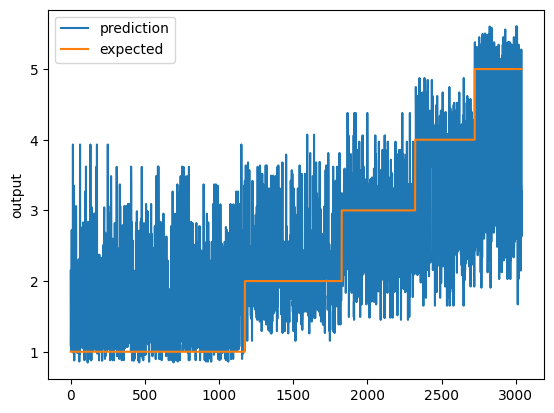

In [ ]:
chart_regression(pred.flatten(),y_test, sort= True)

# Regression using Bag-Of-Words: Anime Data

In [ ]:
# Run this block if you want to run the code on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from sklearn import metrics
from collections.abc import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def xml_to_df(xml):
  xtree = ET.parse(xml)
  xroot = xtree.getroot()

  rows = []

  for node in xroot:
    rows.append(node.attrib)

  return pd.DataFrame(rows)

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [ ]:
# Run this block to get the code from your google drive, otherwise, run the next block
anime = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime2 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime3 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime4 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime5 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime6 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime7 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime8 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")

In [ ]:
anime = xml_to_df(anime)
anime2 = xml_to_df(anime2)
anime3 = xml_to_df(anime3)
anime4 = xml_to_df(anime4)
anime5 = xml_to_df(anime5)
anime6 = xml_to_df(anime6)
anime7 = xml_to_df(anime7)
anime8 = xml_to_df(anime8)

In [ ]:
dataset = pd.concat([anime, anime2, anime3, anime4, anime5, anime6, anime7, anime8], axis=0)
dataset

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ClosedDate,ParentId,OwnerDisplayName,FavoriteCount,LastEditorDisplayName,CommunityOwnedDate
0,1,1,8,2012-12-11T20:37:08.823,83,96054,<p>Assuming the world in the One Piece univers...,21,1398,2015-04-17T19:06:38.957,...,<one-piece>,6,0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,33,2012-12-11T20:39:40.780,14,2535,<p>In the middle of <em>The Dark Tournament</e...,26,247,2013-02-26T17:02:31.570,...,<yu-yu-hakusho>,1,0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,148,2012-12-11T20:42:47.447,12,4893,"<p>In Sora no Otoshimono, Ikaros carries aroun...",29,NaN,NaN,...,<sora-no-otoshimono>,3,1,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,2012-12-11T20:44:46.870,11,20694,<p>Is there any particular software or softwar...,18,111,2013-08-22T12:44:58.107,...,<anime-production>,1,7,CC BY-SA 3.0,2013-02-15T18:24:53.177,NaN,NaN,NaN,NaN,NaN
4,6,1,11,2012-12-11T20:47:21.890,25,9015,"<p>In several episodes of DB:Z and DB:GT, usin...",26,3028,2016-08-22T03:44:55.933,...,<dragon-ball-z><dragon-ball-series><dragon-bal...,6,2,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33421,68281,2,NaN,2023-08-29T18:41:17.330,0,NaN,"<p>I know this was 6 years ago, and I haven't ...",73219,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,NaN,38712,NaN,NaN,NaN,NaN
33422,68282,1,NaN,2023-08-29T21:37:27.507,1,26,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",3028,NaN,NaN,...,<dragon-ball-heroes>,1,0,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN
33423,68283,2,NaN,2023-08-30T01:27:33.613,0,NaN,<p>Being turned into a toy prevents a Devil Fr...,19307,19307,2023-08-30T13:40:41.450,...,NaN,NaN,0,CC BY-SA 4.0,NaN,47521,NaN,NaN,NaN,NaN
33424,68284,2,NaN,2023-09-01T15:33:12.317,0,NaN,<p>Future Gohan powered up to Super Saiyan 2.<...,45593,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,NaN,68282,NaN,NaN,NaN,NaN


In [ ]:
df = dataset.drop(columns=['CreationDate',
                            'OwnerUserId',
                            'LastEditorUserId',
                            'LastEditDate',
                            'LastActivityDate',
                            'Title',
                            'Tags',
                            'AnswerCount',
                            'ContentLicense',
                            'ParentId',
                            'ClosedDate',
                            'CommunityOwnedDate',
                            'LastEditorDisplayName',
                            'OwnerDisplayName',
                            'FavoriteCount',
                            'CommentCount',
                            'PostTypeId',
                            'AcceptedAnswerId',
                            'Id'
                            ])

In [ ]:
df['Score'] = df['Score'].astype(float)
df['ViewCount'] = df['ViewCount'].astype(float)
df['Body'] = df['Body'].astype(str)

In [ ]:
df = df[(df['Score']<=5) & (df['Score']>=1)]
df = df[(df['ViewCount']<=60000) & (df['ViewCount']>=20000)]
df

,Score,ViewCount,Body
336,2.0,39137.0,<p>I've seen the second season so let's start ...
709,4.0,30360.0,<p>Today I just finished watching One Outs and...
1740,5.0,34918.0,"<p>In <em>Bleach</em>, whilst watching the fin..."
1801,2.0,21415.0,"<p>In Naruto series, there are what we called ..."
1888,4.0,25958.0,"<p>In the anime Tsubasa Reservoir Chronicles, ..."
...,...,...,...
30439,4.0,22790.0,<p>Where can I read the original webcomic One ...
30996,2.0,42974.0,<p>I tried to watch it and the audio isn’t Jap...
31008,2.0,22975.0,<p>Since first phase of the <strong>Shingeki n...
31349,2.0,21122.0,<p>At the end of season 2 of the anime <em>Tok...


In [ ]:
df["Body"].replace('[^A-Za-z]+', ' ', regex=True, inplace=True)

In [ ]:
encode_numeric_zscore(df,'ViewCount')

In [ ]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
stop = [stop]
vectorizer = sk_text.TfidfVectorizer(min_df=1, max_features=8000, stop_words=stop)
matrix = vectorizer.fit_transform(df['Body'])
tfidf_data = matrix.toarray()
print(tfidf_data)
print(tfidf_data.shape)
print(vectorizer.get_feature_names_out())
print(len(vectorizer.get_feature_names_out()))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.10041178 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(2176, 3223)
['aa' 'aauoito' 'aaxkqmd' ... 'zoro' 'zou' 'zxv']
3223


In [ ]:
view_count = df['ViewCount'].values
view_count_stack = np.vstack(view_count)
x = np.concatenate((tfidf_data, view_count_stack), axis=1)
y = df['Score']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1740, 3224)
(1740,)
(436, 3224)
(436,)


In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=2, mode='auto')

model.fit(x_train, y_train,callbacks=[monitor],verbose=2,epochs=150)

Epoch 1/150
55/55 - 1s - loss: 6.0262 - 1s/epoch - 23ms/step
Epoch 2/150
55/55 - 0s - loss: 0.5232 - 344ms/epoch - 6ms/step
Epoch 3/150
55/55 - 0s - loss: 0.0513 - 344ms/epoch - 6ms/step
Epoch 4/150
55/55 - 0s - loss: 0.0062 - 364ms/epoch - 7ms/step
Epoch 5/150
55/55 - 0s - loss: 0.0015 - 337ms/epoch - 6ms/step
Epoch 6/150
55/55 - 0s - loss: 4.7392e-04 - 355ms/epoch - 6ms/step
Epoch 7/150
55/55 - 0s - loss: 1.8037e-04 - 353ms/epoch - 6ms/step
Epoch 8/150
55/55 - 0s - loss: 8.7684e-05 - 342ms/epoch - 6ms/step
Epoch 9/150
55/55 - 0s - loss: 4.7077e-05 - 345ms/epoch - 6ms/step
Epoch 10/150
55/55 - 0s - loss: 2.8168e-05 - 343ms/epoch - 6ms/step
Epoch 11/150
55/55 - 0s - loss: 2.2686e-05 - 332ms/epoch - 6ms/step
Epoch 12/150
55/55 - 0s - loss: 1.1475e-04 - 334ms/epoch - 6ms/step
Epoch 13/150
55/55 - 0s - loss: 8.8131e-05 - 347ms/epoch - 6ms/step
Epoch 14/150
55/55 - 0s - loss: 1.8729e-04 - 442ms/epoch - 8ms/step
Epoch 14: early stopping


In [ ]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

14/14 [==============================] - 0s 3ms/step
Score (RMSE): 0.024174496552307606


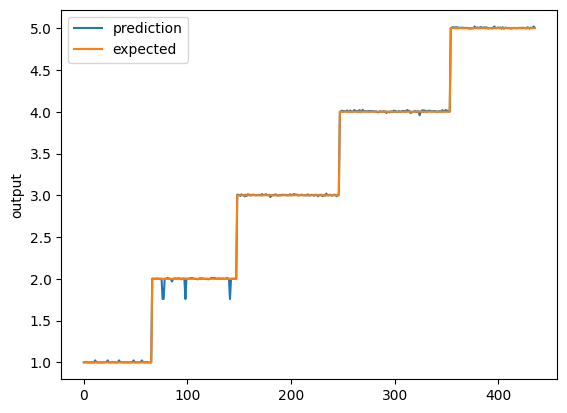

In [ ]:
chart_regression(pred.flatten(),y_test, sort= True)

# Regression using Bag-Of-Words: Apple Data

In [ ]:
# Run this block if you want to run the code on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from sklearn import metrics
from collections.abc import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def xml_to_df(xml):
  xtree = ET.parse(xml)
  xroot = xtree.getroot()

  rows = []

  for node in xroot:
    rows.append(node.attrib)

  return pd.DataFrame(rows)

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [ ]:
# Run this block to get the code from your google drive, otherwise, run the next block
apple = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple2 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple3 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple4 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple5 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple6 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple7 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple8 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")

In [ ]:
apple = xml_to_df(apple)
apple2 = xml_to_df(apple2)
apple2 = xml_to_df(apple3)
apple4 = xml_to_df(apple4)
apple5 = xml_to_df(apple5)
apple6 = xml_to_df(apple6)
apple7 = xml_to_df(apple7)
apple8 = xml_to_df(apple8)

In [ ]:
dataset = pd.concat([apple, apple2, apple3, apple4, apple5, apple6, apple7, apple8], axis=0)
dataset

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ParentId,ClosedDate,CommunityOwnedDate,LastEditorDisplayName,OwnerDisplayName,FavoriteCount
0,1,1,9,2010-08-17T19:22:37.890,16,30430,<p>What is the hardware and software differenc...,10,15,2010-09-08T15:12:04.097,...,<hardware><mac><powerpc><macos>,9,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,130,2010-08-17T19:24:59.630,9,6437,"<p>The VPN software I use for work (<a href=""h...",17,17,2010-08-28T17:59:50.107,...,<macos><mobileme><terminal><back-to-my-mac><sc...,1,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,13,2010-08-17T19:25:11.097,8,740,<p>I have Microsoft Office/2008 on my MacBook ...,15,15,2010-09-25T17:22:15.797,...,<software><ms-office>,3,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,6,2010-08-17T19:26:12.013,5,1039,<p>I had a power failure and upon rebooting no...,18,NaN,NaN,...,<macos><snow-leopard>,2,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,2010-08-17T19:27:56.923,26,21206,<p>I will often click on a button expecting it...,11,NaN,NaN,...,<mouse>,4,3,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317587,463853,2,NaN,2023-09-02T23:20:48.897,0,NaN,"<p><a href=""https://redd.it/167dc55"" rel=""nofo...",20338,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,463809,NaN,NaN,NaN,NaN,NaN
317588,463854,2,NaN,2023-09-02T23:40:37.157,0,NaN,<p>Besides AirDrop have you tried another meth...,669,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,463841,NaN,NaN,NaN,NaN,NaN
317589,463855,1,NaN,2023-09-02T23:56:43.603,1,10,<p>When I edit an (e.g.) PNG file in Preview.a...,25478,NaN,NaN,...,<preview><image-editing>,0,3,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN
317590,463856,1,NaN,2023-09-03T00:25:39.043,1,10,<p>My <em>uncle</em> has the following MacBook...,348694,107222,2023-09-03T01:56:45.603,...,<macos><hardware><upgrade><memory><hardware-re...,0,1,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = dataset.drop(columns=['CreationDate',
                            'OwnerUserId',
                            'LastEditorUserId',
                            'LastEditDate',
                            'LastActivityDate',
                            'Title',
                            'Tags',
                            'AnswerCount',
                            'ContentLicense',
                            'ParentId',
                            'ClosedDate',
                            'CommunityOwnedDate',
                            'LastEditorDisplayName',
                            'OwnerDisplayName',
                            'FavoriteCount',
                            'CommentCount',
                            'PostTypeId',
                            'AcceptedAnswerId',
                            'Id'
                            ])

In [ ]:
df['Score'] = df['Score'].astype(float)
df['ViewCount'] = df['ViewCount'].astype(float)
df['Body'] = df['Body'].astype(str)

In [ ]:
df = df[(df['Score']<=5) & (df['Score']>=1)]
df = df[(df['ViewCount']<=60000) & (df['ViewCount']>=20000)]
df

,Score,ViewCount,Body
506,3.0,29804.0,<p>Including all e-mail messages contained in ...
598,4.0,31076.0,"<p>Ideally, I'm looking for free or low-cost s..."
1034,2.0,27432.0,<p>What's the default Notes account setting us...
1489,3.0,21984.0,<p>A large proportion of contacts I have gaine...
1791,5.0,21050.0,<p>Which software/hardware can turn my iPhone ...
...,...,...,...
299058,3.0,22152.0,<p>On the Terminal commandline I tried:</p>\n<...
299525,3.0,20111.0,<p>I tried to follow the existing guides expla...
300497,4.0,24907.0,<p>When I'm listening to music on my iOS devic...
306665,5.0,22161.0,<p>I update my iPad (gen 8) to the newest iPad...


In [ ]:
df["Body"].replace('[^A-Za-z]+', ' ', regex=True, inplace=True)

In [ ]:
encode_numeric_zscore(df,'ViewCount')

In [ ]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
stop = [stop]
vectorizer = sk_text.TfidfVectorizer(min_df=1, max_features=8000, stop_words=stop)
matrix = vectorizer.fit_transform(df['Body'])
tfidf_data = matrix.toarray()
print(tfidf_data)
print(tfidf_data.shape)
print(vectorizer.get_feature_names_out())
print(len(vectorizer.get_feature_names_out()))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(16944, 8000)
['aa' 'aaaand' 'aab' ... 'zthr' 'zurzf' 'zvwrn']
8000


In [ ]:
view_count = df['ViewCount'].values
view_count_stack = np.vstack(view_count)
x = np.concatenate((tfidf_data, view_count_stack), axis=1)
y = df['Score']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13555, 8001)
(13555,)
(3389, 8001)
(3389,)


In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=2, mode='auto')

model.fit(x_train, y_train,callbacks=[monitor],verbose=2,epochs=150)

Epoch 1/150
424/424 - 8s - loss: 1.5041 - 8s/epoch - 19ms/step
Epoch 2/150
424/424 - 5s - loss: 0.0569 - 5s/epoch - 11ms/step
Epoch 3/150
424/424 - 5s - loss: 0.0219 - 5s/epoch - 11ms/step
Epoch 4/150
424/424 - 7s - loss: 0.0194 - 7s/epoch - 15ms/step
Epoch 5/150
424/424 - 5s - loss: 0.0188 - 5s/epoch - 11ms/step
Epoch 6/150
424/424 - 5s - loss: 0.0167 - 5s/epoch - 11ms/step
Epoch 7/150
424/424 - 6s - loss: 0.0155 - 6s/epoch - 14ms/step
Epoch 8/150
424/424 - 5s - loss: 0.0171 - 5s/epoch - 13ms/step
Epoch 9/150
424/424 - 5s - loss: 0.0141 - 5s/epoch - 11ms/step
Epoch 10/150
424/424 - 6s - loss: 0.0082 - 6s/epoch - 13ms/step
Epoch 11/150
424/424 - 6s - loss: 0.0137 - 6s/epoch - 13ms/step
Epoch 12/150
424/424 - 5s - loss: 0.0115 - 5s/epoch - 11ms/step
Epoch 13/150
424/424 - 5s - loss: 0.0095 - 5s/epoch - 12ms/step
Epoch 14/150
424/424 - 6s - loss: 0.0095 - 6s/epoch - 14ms/step
Epoch 15/150
424/424 - 5s - loss: 0.0082 - 5s/epoch - 11ms/step
Epoch 15: early stopping


In [ ]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

106/106 [==============================] - 1s 9ms/step
Score (RMSE): 0.09929753995383911


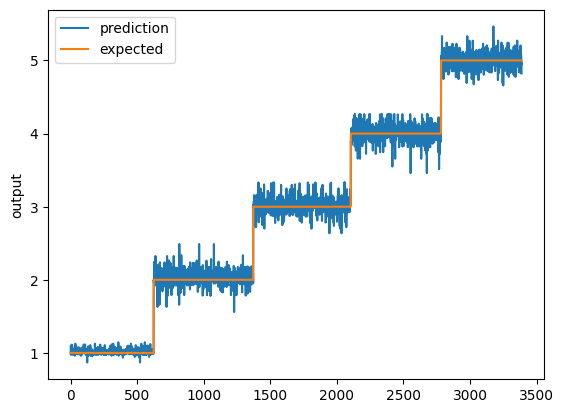

In [ ]:
chart_regression(pred.flatten(),y_test, sort= True)

# Regression using Bag-Of-Words: Apple and Anime Data

In [ ]:
# Run this block if you want to run the code on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from sklearn import metrics
from collections.abc import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def xml_to_df(xml):
  xtree = ET.parse(xml)
  xroot = xtree.getroot()

  rows = []

  for node in xroot:
    rows.append(node.attrib)

  return pd.DataFrame(rows)

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [ ]:
# Run this block to get the code from your google drive, otherwise, run the next block
apple = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple2 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple3 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
apple4 = os.path.join("/content/drive/MyDrive/Datasets/apple/Posts.xml")
anime = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime2 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime3 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")
anime4 = os.path.join("/content/drive/MyDrive/Datasets/anime/Posts.xml")

In [ ]:
apple = xml_to_df(apple)
apple2 = xml_to_df(apple2)
apple3 = xml_to_df(apple3)
apple4 = xml_to_df(apple4)
anime = xml_to_df(anime5)
anime2 = xml_to_df(anime6)
anime3 = xml_to_df(anime7)
anime4 = xml_to_df(anime8)

In [ ]:
dataset = pd.concat([apple, apple2, apple3, apple4, anime, anime2, anime3, anime4], axis=0)
dataset

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ParentId,ClosedDate,CommunityOwnedDate,LastEditorDisplayName,OwnerDisplayName,FavoriteCount
0,1,1,9,2010-08-17T19:22:37.890,16,30430,<p>What is the hardware and software differenc...,10,15,2010-09-08T15:12:04.097,...,<hardware><mac><powerpc><macos>,9,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,130,2010-08-17T19:24:59.630,9,6437,"<p>The VPN software I use for work (<a href=""h...",17,17,2010-08-28T17:59:50.107,...,<macos><mobileme><terminal><back-to-my-mac><sc...,1,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,13,2010-08-17T19:25:11.097,8,740,<p>I have Microsoft Office/2008 on my MacBook ...,15,15,2010-09-25T17:22:15.797,...,<software><ms-office>,3,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,6,2010-08-17T19:26:12.013,5,1039,<p>I had a power failure and upon rebooting no...,18,NaN,NaN,...,<macos><snow-leopard>,2,0,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,2010-08-17T19:27:56.923,26,21206,<p>I will often click on a button expecting it...,11,NaN,NaN,...,<mouse>,4,3,CC BY-SA 2.5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33421,68281,2,NaN,2023-08-29T18:41:17.330,0,NaN,"<p>I know this was 6 years ago, and I haven't ...",73219,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,38712,NaN,NaN,NaN,NaN,NaN
33422,68282,1,NaN,2023-08-29T21:37:27.507,1,26,"<p>In Dragon Ball Heroes episode 50,</p>\n<blo...",3028,NaN,NaN,...,<dragon-ball-heroes>,1,0,CC BY-SA 4.0,NaN,NaN,NaN,NaN,NaN,NaN
33423,68283,2,NaN,2023-08-30T01:27:33.613,0,NaN,<p>Being turned into a toy prevents a Devil Fr...,19307,19307,2023-08-30T13:40:41.450,...,NaN,NaN,0,CC BY-SA 4.0,47521,NaN,NaN,NaN,NaN,NaN
33424,68284,2,NaN,2023-09-01T15:33:12.317,0,NaN,<p>Future Gohan powered up to Super Saiyan 2.<...,45593,NaN,NaN,...,NaN,NaN,0,CC BY-SA 4.0,68282,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = dataset.drop(columns=['CreationDate',
                            'OwnerUserId',
                            'LastEditorUserId',
                            'LastEditDate',
                            'LastActivityDate',
                            'Title',
                            'Tags',
                            'AnswerCount',
                            'ContentLicense',
                            'ParentId',
                            'ClosedDate',
                            'CommunityOwnedDate',
                            'LastEditorDisplayName',
                            'OwnerDisplayName',
                            'FavoriteCount',
                            'CommentCount',
                            'PostTypeId',
                            'AcceptedAnswerId',
                            'Id'
                            ])

In [ ]:
df['Score'] = df['Score'].astype(float)
df['ViewCount'] = df['ViewCount'].astype(float)
df['Body'] = df['Body'].astype(str)

In [ ]:
df = df[(df['Score']<=5) & (df['Score']>=1)]
df = df[(df['ViewCount']<=60000) & (df['ViewCount']>=20000)]
df

,Score,ViewCount,Body
506,3.0,29804.0,<p>Including all e-mail messages contained in ...
598,4.0,31076.0,"<p>Ideally, I'm looking for free or low-cost s..."
1034,2.0,27432.0,<p>What's the default Notes account setting us...
1489,3.0,21984.0,<p>A large proportion of contacts I have gaine...
1791,5.0,21050.0,<p>Which software/hardware can turn my iPhone ...
...,...,...,...
30439,4.0,22790.0,<p>Where can I read the original webcomic One ...
30996,2.0,42974.0,<p>I tried to watch it and the audio isn’t Jap...
31008,2.0,22975.0,<p>Since first phase of the <strong>Shingeki n...
31349,2.0,21122.0,<p>At the end of season 2 of the anime <em>Tok...


In [ ]:
df["Body"].replace('[^A-Za-z]+', ' ', regex=True, inplace=True)

In [ ]:
encode_numeric_zscore(df,'ViewCount')

In [ ]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
stop = [stop]
vectorizer = sk_text.TfidfVectorizer(min_df=1, max_features=8000, stop_words=stop)
matrix = vectorizer.fit_transform(df['Body'])
tfidf_data = matrix.toarray()
print(tfidf_data)
print(tfidf_data.shape)
print(vectorizer.get_feature_names_out())
print(len(vectorizer.get_feature_names_out()))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(9560, 8000)
['aa' 'aaaand' 'aab' ... 'zvwrn' 'zx' 'zxv']
8000


In [ ]:
view_count = df['ViewCount'].values
view_count_stack = np.vstack(view_count)
x = np.concatenate((tfidf_data, view_count_stack), axis=1)
y = df['Score']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7648, 8001)
(7648,)
(1912, 8001)
(1912,)


In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=2, mode='auto')

model.fit(x_train, y_train,callbacks=[monitor],verbose=2,epochs=150)

Epoch 1/150
239/239 - 5s - loss: 2.3225 - 5s/epoch - 19ms/step
Epoch 2/150
239/239 - 4s - loss: 0.3259 - 4s/epoch - 16ms/step
Epoch 3/150
239/239 - 4s - loss: 0.0732 - 4s/epoch - 15ms/step
Epoch 4/150
239/239 - 3s - loss: 0.0367 - 3s/epoch - 11ms/step
Epoch 5/150
239/239 - 3s - loss: 0.0314 - 3s/epoch - 11ms/step
Epoch 6/150
239/239 - 3s - loss: 0.0273 - 3s/epoch - 11ms/step
Epoch 7/150
239/239 - 3s - loss: 0.0253 - 3s/epoch - 14ms/step
Epoch 8/150
239/239 - 4s - loss: 0.0236 - 4s/epoch - 16ms/step
Epoch 9/150
239/239 - 3s - loss: 0.0220 - 3s/epoch - 12ms/step
Epoch 10/150
239/239 - 3s - loss: 0.0223 - 3s/epoch - 11ms/step
Epoch 11/150
239/239 - 3s - loss: 0.0170 - 3s/epoch - 11ms/step
Epoch 12/150
239/239 - 3s - loss: 0.0169 - 3s/epoch - 11ms/step
Epoch 13/150
239/239 - 4s - loss: 0.0179 - 4s/epoch - 15ms/step
Epoch 14/150
239/239 - 4s - loss: 0.0190 - 4s/epoch - 16ms/step
Epoch 15/150
239/239 - 3s - loss: 0.0152 - 3s/epoch - 11ms/step
Epoch 16/150
239/239 - 3s - loss: 0.0139 - 3s/epo

In [ ]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

60/60 [==============================] - 0s 5ms/step
Score (RMSE): 0.18071918451305719


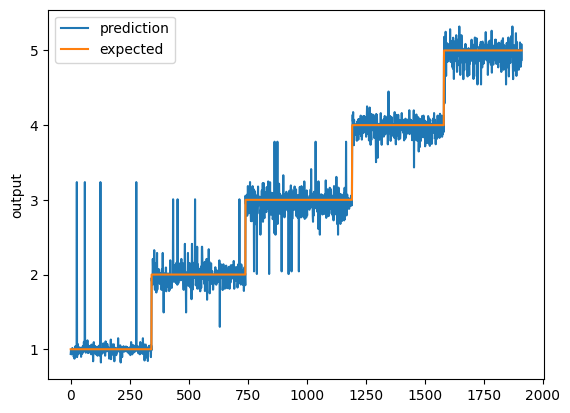

In [ ]:
chart_regression(pred.flatten(),y_test, sort= True)

# RNN Classification using LSTM

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from collections.abc import Sequence


In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def xml_to_df(xml):
  xtree = ET.parse(xml)
  xroot = xtree.getroot()

  rows = []

  for node in xroot:
    rows.append(node.attrib)

  return pd.DataFrame(rows)

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [ ]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("valid.csv")

In [ ]:
train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [ ]:
validation.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT


## **Data Cleanup**

In [ ]:
#remove unwanted HTML tags using regular expressions,
#replace tags with blank spaces

import re

def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>', '', str(text))
    return clean_text

def format(tag):
    cleaned_tag = tag.replace(">", " ").replace("<", "")
    return cleaned_tag

In [ ]:
train['Cleaned_Body'] = [remove_html_tags(body) for body in train['Body']]
train['Formatted_Tags'] = [format(tag) for tag in train['Tags']]

validation['Cleaned_Body'] = [remove_html_tags(body) for body in validation['Body']]
validation['Formatted_Tags'] = [format(tag) for tag in validation['Tags']]


In [ ]:
# Vocabulary size
max_words = 10_000

In [ ]:
# Prepare label for training set
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train['Y'])
train_labels_categorical = to_categorical(train_labels_encoded, num_classes=3)

# Prepare label for validation set
validation_labels_encoded = label_encoder.transform(validation['Y'])
validation_labels_categorical = to_categorical(validation_labels_encoded, num_classes=3)

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['Cleaned_Body'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train['Cleaned_Body'])
val_sequences = tokenizer.texts_to_sequences(validation['Cleaned_Body'])

# Pad sequences
max_len = 200
train_data_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_data_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')

## **Model 1**:
##### *embedding_dim = 64*
##### *lstm1_dim = 64*
##### *lstm2_dim = 32*
##### *dense_dim = 64*



In [ ]:
# Determine the actual number of unique words in tokenizer
actual_num_words = len(tokenizer.word_index) + 1  # Add 1 for the padding token

# Use the actual number of unique words as max_features
max_features = actual_num_words

# Hyperparameters

batch_size = 64
timesteps = 200

embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

2023-11-26 21:01:14.682996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:01:14.683461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 21:01:14.684018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          12259520  
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 12,371,139
Trainable params: 12,371,139


2023-11-26 21:01:14.889460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-11-26 21:01:14.906259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:01:14.906699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
monitor = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

history = model.fit(
    train_data_padded[:500],
    train_labels_categorical[:500],
    validation_data=(val_data_padded[:500], validation_labels_categorical[:500]),
    epochs=10,
    batch_size=batch_size
)


Epoch 1/10


8/8 [==============================] - 2s 298ms/step - loss: 6.0215e-04 - accuracy: 1.0000 - val_loss: 1.0804 - val_accuracy: 0.7040
Epoch 2/10
8/8 [==============================] - 2s 293ms/step - loss: 5.3581e-04 - accuracy: 1.0000 - val_loss: 1.0965 - val_accuracy: 0.7020
Epoch 3/10
8/8 [==============================] - 2s 298ms/step - loss: 4.7664e-04 - accuracy: 1.0000 - val_loss: 1.1117 - val_accuracy: 0.7020
Epoch 4/10
8/8 [==============================] - 2s 304ms/step - loss: 4.3028e-04 - accuracy: 1.0000 - val_loss: 1.1231 - val_accuracy: 0.7080
Epoch 5/10
8/8 [==============================] - 2s 297ms/step - loss: 3.8923e-04 - accuracy: 1.0000 - val_loss: 1.1347 - val_accuracy: 0.7100
Epoch 6/10
8/8 [==============================] - 2s 290ms/step - loss: 3.5480e-04 - accuracy: 1.0000 - val_loss: 1.1458 - val_accuracy: 0.7100
Epoch 7/10
8/8 [==============================] - 2s 292ms/step - loss: 3.2485e-04 - accuracy: 1.0000 - val_loss: 1.1576 - val_accuracy: 0.7100
Epo

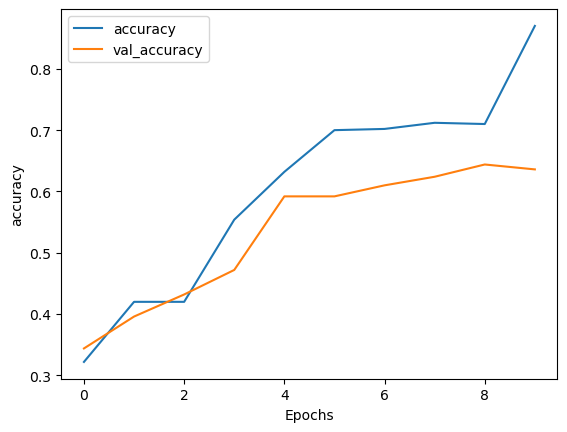

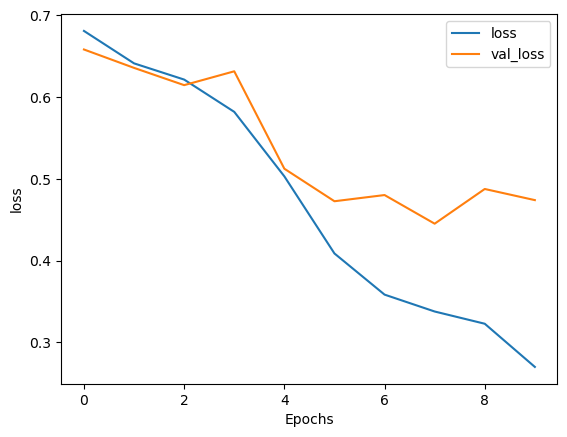

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
val_loss, val_accuracy = model.evaluate(val_data_padded, validation_labels_categorical)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get true labels
y_true = np.argmax(validation_labels_categorical, axis=1)

# Make predictions
preds = model.predict(val_data_padded)
class_preds = np.argmax(preds, axis=1)

# Calculate precision, recall, and F1 score
precision = metrics.precision_score(y_true, class_preds, average="weighted")
recall = metrics.recall_score(y_true, class_preds, average="weighted")
f1 = metrics.f1_score(y_true, class_preds, average="weighted")

# Print classification report
print(metrics.classification_report(y_true, class_preds))

# Print individual scores
print("Precision score: {:.4f}".format(precision))
print("Recall score: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1))
print("Final accuracy: {:.4f}".format(val_accuracy))

# Print class predictions
print("Class Predictions:", class_preds)

469/469 [==============================] - 11s 24ms/step - loss: 1.1930 - accuracy: 0.7196
Validation Loss: 1.1930
Validation Accuracy: 0.7196
469/469 [==============================] - 11s 23ms/step
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      5000
           1       0.60      0.69      0.64      5000
           2       0.93      0.83      0.88      5000

    accuracy                           0.72     15000
   macro avg       0.73      0.72      0.72     15000
weighted avg       0.73      0.72      0.72     15000

Precision score: 0.7323
Recall score: 0.7196
F1 score: 0.7237
Final accuracy: 0.7196
Class Predictions: [2 2 0 ... 2 1 0]


## **Model 2**:
##### *added learning rate and droupout rate*
##### *learning_rate = 0.001*
##### *dropout_rate = 0.3*


In [ ]:
batch_size = 64
timesteps = 200

embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

learning_rate = 0.001
dropout_rate = 0.3

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

2023-11-26 21:58:16.017763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:58:16.018565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 21:58:16.019416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          12259520  
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 12,371,139
Trainable params: 12,371,139


2023-11-26 21:58:16.236375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-11-26 21:58:16.256289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:58:16.256782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

history = model.fit(
    train_data_padded[:500],
    train_labels_categorical[:500],
    validation_data=(val_data_padded[:500], validation_labels_categorical[:500]),
    epochs=10,
    batch_size=batch_size
)

Epoch 1/10


2023-11-26 21:58:52.653623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:58:52.654261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 21:58:52.654839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.3040

2023-11-26 21:58:57.379600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:58:57.380241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 21:58:57.380994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 6s 391ms/step - loss: 0.6806 - accuracy: 0.3040 - val_loss: 0.6585 - val_accuracy: 0.2780
Epoch 2/10
8/8 [==============================] - 2s 294ms/step - loss: 0.6398 - accuracy: 0.3600 - val_loss: 0.6404 - val_accuracy: 0.3960
Epoch 3/10
8/8 [==============================] - 2s 282ms/step - loss: 0.6189 - accuracy: 0.4820 - val_loss: 0.6018 - val_accuracy: 0.5320
Epoch 4/10
8/8 [==============================] - 2s 317ms/step - loss: 0.5658 - accuracy: 0.6040 - val_loss: 0.5490 - val_accuracy: 0.5620
Epoch 5/10
8/8 [==============================] - 2s 293ms/step - loss: 0.4911 - accuracy: 0.6360 - val_loss: 0.4962 - val_accuracy: 0.5880
Epoch 6/10
8/8 [==============================] - 2s 306ms/step - loss: 0.4173 - accuracy: 0.6640 - val_loss: 0.4596 - val_accuracy: 0.5980
Epoch 7/10
8/8 [==============================] - 2s 313ms/step - loss: 0.3681 - accuracy: 0.6900 - val_loss: 0.4663 - val_accuracy: 0.5900
Epoch 8/10
8/8 [===============

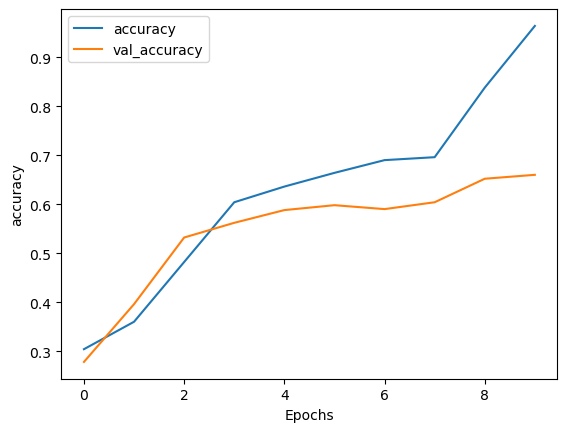

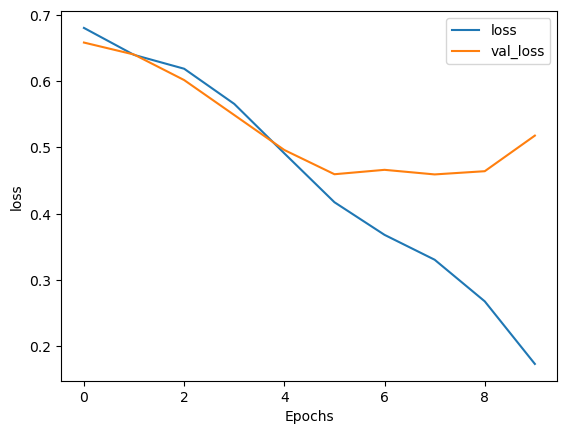

469/469 [==============================] - 11s 24ms/step - loss: 0.5372 - accuracy: 0.6410
Validation Loss: 0.5372
Validation Accuracy: 0.6410


2023-11-26 21:59:43.066549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 21:59:43.067126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 21:59:43.067826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 12s 24ms/step
              precision    recall  f1-score   support

           0       0.49      0.90      0.64      5000
           1       0.66      0.21      0.32      5000
           2       0.95      0.81      0.88      5000

    accuracy                           0.64     15000
   macro avg       0.70      0.64      0.61     15000
weighted avg       0.70      0.64      0.61     15000

Precision score: 0.7009
Recall score: 0.6410
F1 score: 0.6110
Final accuracy: 0.6410
Class Predictions: [2 2 0 ... 2 0 0]


In [ ]:
# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

val_loss, val_accuracy = model.evaluate(val_data_padded, validation_labels_categorical)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get true labels
y_true = np.argmax(validation_labels_categorical, axis=1)

# Make predictions
preds = model.predict(val_data_padded)
class_preds = np.argmax(preds, axis=1)

# Calculate precision, recall, and F1 score
precision = metrics.precision_score(y_true, class_preds, average="weighted")
recall = metrics.recall_score(y_true, class_preds, average="weighted")
f1 = metrics.f1_score(y_true, class_preds, average="weighted")

# Print classification report
print(metrics.classification_report(y_true, class_preds))

# Print individual scores
print("Precision score: {:.4f}".format(precision))
print("Recall score: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1))
print("Final accuracy: {:.4f}".format(val_accuracy))

# Print class predictions
print("Class Predictions:", class_preds)

## **Model 3**:
##### *Removed learning rate and droupout rate*
##### *embedding_dim = 100*
##### *lstm1_dim = 128*
##### *lstm2_dim = 64*
##### *dense_dim = 128*

In [ ]:
batch_size = 64
timesteps = 200

embedding_dim = 64
lstm1_dim = 128
lstm2_dim = 64
dense_dim = 128

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

2023-11-26 22:03:48.799304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 22:03:48.800231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 22:03:48.800807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          12259520  
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 256)        197632    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 12,638,403
Trainable params: 12,638,403


2023-11-26 22:03:49.014532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-11-26 22:03:49.033158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 22:03:49.033945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

history = model.fit(
    train_data_padded[:500],
    train_labels_categorical[:500],
    validation_data=(val_data_padded[:500], validation_labels_categorical[:500]),
    epochs=10,
    batch_size=batch_size
)

Epoch 1/10


2023-11-26 22:04:12.698759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 22:04:12.699371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 22:04:12.699955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.3780

2023-11-26 22:04:18.553844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 22:04:18.555211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 22:04:18.555980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 8s 681ms/step - loss: 0.6742 - accuracy: 0.3780 - val_loss: 0.6369 - val_accuracy: 0.3960
Epoch 2/10
8/8 [==============================] - 5s 640ms/step - loss: 0.6272 - accuracy: 0.4160 - val_loss: 0.6111 - val_accuracy: 0.4760
Epoch 3/10
8/8 [==============================] - 5s 650ms/step - loss: 0.5373 - accuracy: 0.6000 - val_loss: 0.5421 - val_accuracy: 0.5440
Epoch 4/10
8/8 [==============================] - 5s 588ms/step - loss: 0.4197 - accuracy: 0.6760 - val_loss: 0.5116 - val_accuracy: 0.5940
Epoch 5/10
8/8 [==============================] - 5s 607ms/step - loss: 0.3234 - accuracy: 0.7760 - val_loss: 0.4516 - val_accuracy: 0.6620
Epoch 6/10
8/8 [==============================] - 5s 640ms/step - loss: 0.2208 - accuracy: 0.9120 - val_loss: 0.4604 - val_accuracy: 0.6780
Epoch 7/10
8/8 [==============================] - 5s 591ms/step - loss: 0.1133 - accuracy: 0.9640 - val_loss: 0.5557 - val_accuracy: 0.6700
Epoch 8/10
8/8 [===============

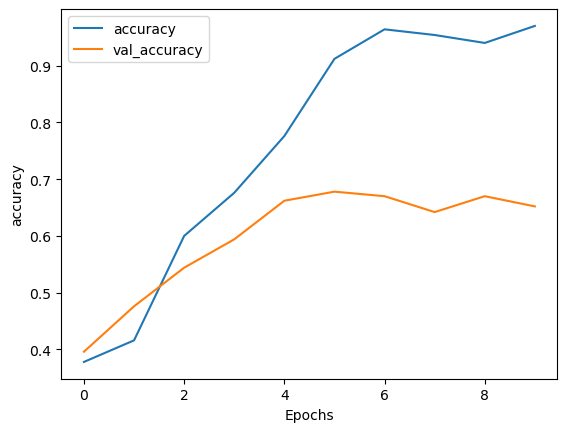

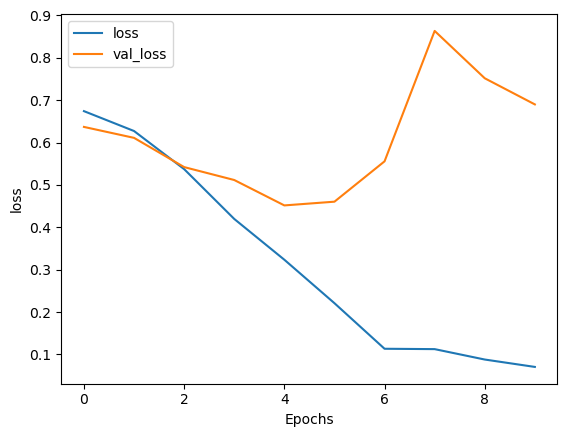

469/469 [==============================] - 48s 103ms/step - loss: 0.6360 - accuracy: 0.6765
Validation Loss: 0.6360
Validation Accuracy: 0.6765


2023-11-26 22:05:55.873198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-26 22:05:55.873928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-26 22:05:55.874528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 48s 102ms/step
              precision    recall  f1-score   support

           0       0.73      0.40      0.52      5000
           1       0.52      0.83      0.64      5000
           2       0.94      0.80      0.87      5000

    accuracy                           0.68     15000
   macro avg       0.73      0.68      0.67     15000
weighted avg       0.73      0.68      0.67     15000

Precision score: 0.7308
Recall score: 0.6765
F1 score: 0.6734
Final accuracy: 0.6765
Class Predictions: [2 2 0 ... 2 1 1]


In [ ]:
# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

val_loss, val_accuracy = model.evaluate(val_data_padded, validation_labels_categorical)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get true labels
y_true = np.argmax(validation_labels_categorical, axis=1)

# Make predictions
preds = model.predict(val_data_padded)
class_preds = np.argmax(preds, axis=1)

# Calculate precision, recall, and F1 score
precision = metrics.precision_score(y_true, class_preds, average="weighted")
recall = metrics.recall_score(y_true, class_preds, average="weighted")
f1 = metrics.f1_score(y_true, class_preds, average="weighted")

# Print classification report
print(metrics.classification_report(y_true, class_preds))

# Print individual scores
print("Precision score: {:.4f}".format(precision))
print("Recall score: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1))
print("Final accuracy: {:.4f}".format(val_accuracy))

# Print class predictions
print("Class Predictions:", class_preds)

In [ ]:
%shell
jupyter nbconvert --to html /content/Final.ipynb

SyntaxError: ignored